<a href="https://colab.research.google.com/github/Hamza1407/AnalyseTemp/blob/main/TIME_SERIES_AMTE1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data wrangling and Times series forecasting for AMTE 1**

We’ll first look at the project and describe the data that we’ll use. Then we’ll cover the data wrangling and preprocess- ing steps.
Although those steps do not relate directly to time series forecasting, they are crucial steps in any machine learning project. We’ll then focus on the modeling steps, where we’ll try a set of deep learning models to uncover the best performer.


The steps that will allow us to fo throught this journey are :

Data preprocessing :

1) Combining the Date and Time columns into a DateTime object and remove columns to keep a 2 columns dataset : DateTime and the value.

2) Calculate the number of missing values, if any impute the missing values.

Feature engineering:

3) Identify any seasonality.

4) Encode the time with a sine and cosine transformation.

5) Scale the data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime


In [2]:
df=pd.read_csv('/content/AMTE1.csv',sep=';')

### **Data preprocessing**

In [3]:
df['Date et Heure']=df['Date de la mesure']+' '+df['Heure de la mesure']
df=df.drop(['Date de la mesure','Heure de la mesure'],axis=1)
df['Date et Heure']=pd.to_datetime(df['Date et Heure'], format='%d/%m/%Y %H:%M:%S')

df

,Valeur,Date et Heure
0,129000.0,2020-10-19 00:00:00
1,127000.0,2020-10-19 00:30:00
2,134000.0,2020-10-19 01:00:00
3,151000.0,2020-10-19 01:30:00
4,142000.0,2020-10-19 02:00:00
...,...,...
38583,22000.0,2022-12-31 21:30:00
38584,22000.0,2022-12-31 22:00:00
38585,21000.0,2022-12-31 22:30:00
38586,22000.0,2022-12-31 23:00:00


In [4]:
df.isna().sum()

Valeur           0
Date et Heure    0
dtype: int64

There is no missing values as we can see.

### **Features engineering**

With our target being global active power, it is likely that we’ll have some seasonality. We can expect that at night, less electrical power will be used. Similarly, there may be a peak in consumption when people come back from work during the week. Thus, it is reasonable to assume that there will be some seasonality in our target.
We can plot our target to see if we can visually detect the period.


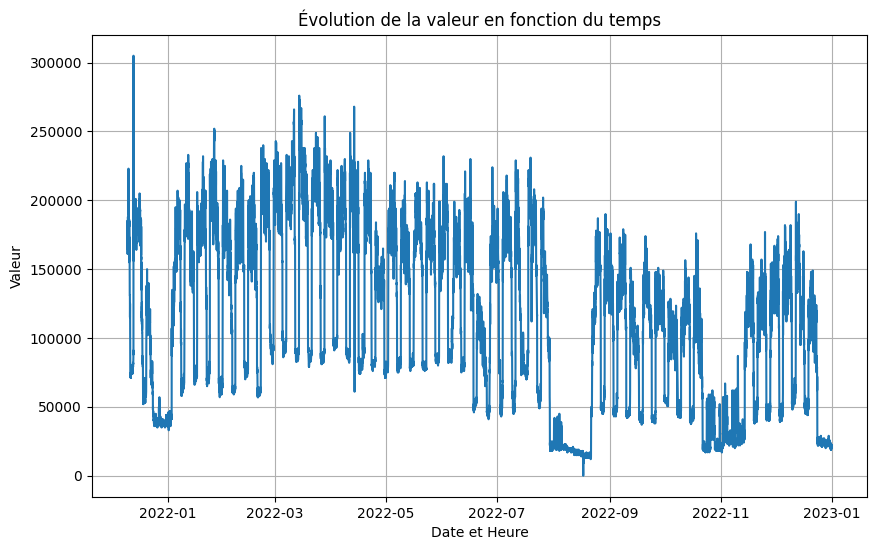

In [5]:
df = df.sort_values(by='Date et Heure')



# Tracer l'évolution de la valeur en fonction du temps
plt.figure(figsize=(10, 6))
plt.plot(df.loc[20000:,:]['Date et Heure'], df.loc[20000:,:]['Valeur'], linestyle='-')
plt.title('Évolution de la valeur en fonction du temps')
plt.xlabel('Date et Heure')
plt.ylabel('Valeur')
plt.grid(True)
plt.show()

In the figure we can see that our target has some cyclical behavior, but the seasonal period is hard to determine from the graph. While our hypothesis about daily season- ality makes sense, we need to make sure that it is present in our data. One way to do it is with a Fourier transform.

Without diving into the details, we can treat our time series as a signal, apply a Fourier transform, and find the frequencies with large amplitudes. Those frequencies will determine the seasonal period. The great advantage of this method is that it is independent of the seasonal period. It can identify yearly, weekly, and daily seasonality, or any specific period we wish to test.


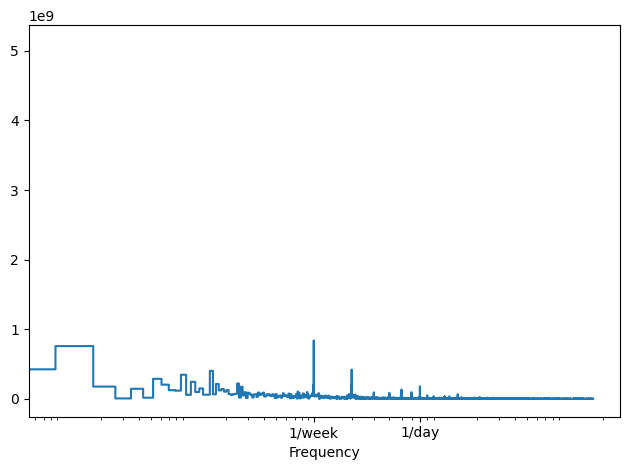

In [6]:
fft = tf.signal.rfft(df['Valeur'])



f_per_dataset = np.arange(0, len(fft))
n_sample_h = len(df['Valeur'])/2

hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week
f_per_week = f_per_dataset / weeks_per_dataset
plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()


We can see the amplitude of the weekly and daily frequencies.
- The weekly frequency is showing the most visible peak, meaning that its amplitude is big. Therefore, there is no weekly seasonality.  
- The daily frequency does not show any big peak, meaning that its amplitude is small. Therefore, there is no important daily seasonality.

Let's try to see if we can really see this weekly seasonality by displaying data for different consecutive weeks.

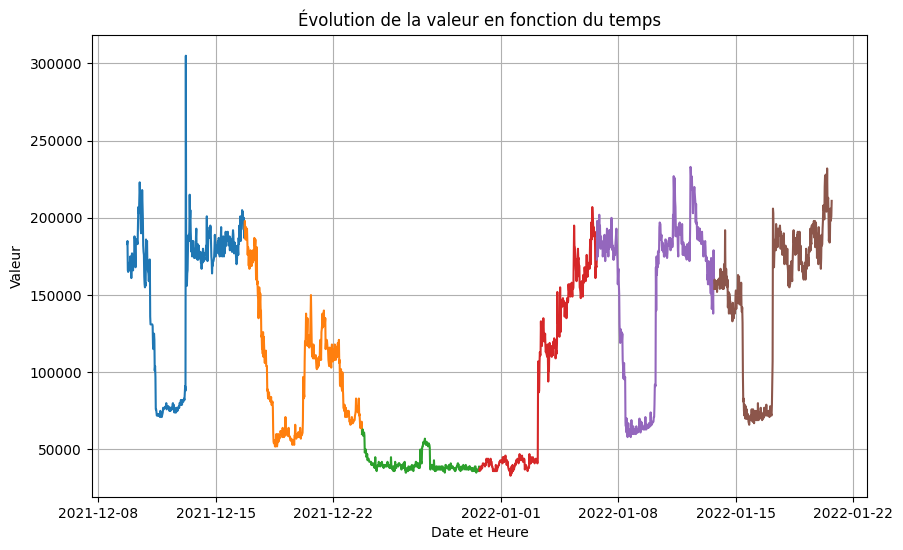

In [7]:
df = df.sort_values(by='Date et Heure')



# Tracer l'évolution de la valeur en fonction du temps
plt.figure(figsize=(10, 6))
plt.plot(df.loc[20000:20336,:]['Date et Heure'], df.loc[20000:20336,:]['Valeur'], linestyle='-')
plt.plot(df.loc[20336:20672,:]['Date et Heure'], df.loc[20336:20672,:]['Valeur'], linestyle='-')
plt.plot(df.loc[20672:20672+336,:]['Date et Heure'], df.loc[20672:20672+336,:]['Valeur'], linestyle='-')
plt.plot(df.loc[20672+336:20672+336+336,:]['Date et Heure'], df.loc[20672+336:20672+336+336,:]['Valeur'], linestyle='-')
plt.plot(df.loc[20672+336+336:20672+336+336+336,:]['Date et Heure'], df.loc[20672+336+336:20672+336+336+336,:]['Valeur'], linestyle='-')
plt.plot(df.loc[20672+336+336+336:20672+336+336+336+336,:]['Date et Heure'], df.loc[20672+336+336+336:20672+336+336+336+336,:]['Valeur'], linestyle='-')


plt.title('Évolution de la valeur en fonction du temps')
plt.xlabel('Date et Heure')
plt.ylabel('Valeur')
plt.grid(True)
plt.show()

The data shows a clear weekly periodicity, with a consistent pattern observed throughout most weeks. However, there is a subtle deviation during the two weeks in the middle, which appears to be attributable to the Christmas vacation period.

Now we reach the interesting problem of encoding time as a usable feature for our deep learning models.

Right now, the date_time feature is not usable by our models, since it is a datetime string. We will thus convert it into a numerical value.

A simple way to do that is to express the date as a number of seconds.
This leads us to losing the cyclical nature of time, because the number of seconds simply increases linearly with time.

Therefore, we must apply a transformation to recover the cyclical behavior of time. A simple way to do that is to apply a sine transformation.


In [8]:
timestamp_s =pd.to_datetime(df['Date et Heure']).map(datetime.datetime.timestamp)
week = 7*24 * 60 * 60
df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/week))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/week))).values
df = df.drop(['Date et Heure'], axis=1)

In [9]:
df

,Valeur,day_sin,day_cos
0,129000.0,-0.433884,-0.900969
1,127000.0,-0.450655,-0.892698
2,134000.0,-0.467269,-0.884115
3,151000.0,-0.483719,-0.875223
4,142000.0,-0.500000,-0.866025
...,...,...,...
38583,22000.0,0.516106,-0.856525
38584,22000.0,0.500000,-0.866025
38585,21000.0,0.483719,-0.875223
38586,22000.0,0.467269,-0.884115


Our feature engineering is complete, and the data is ready to be scaled and split into training, validation, and test sets.